# Code to calculate correlations from the simulation (one-file at a time)


In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.stats import spearmanr
from joblib import Parallel, delayed
import warnings
import gc
import matplotlib.pyplot as plt
import argparse
from tqdm.auto import tqdm

### Utility functions


In [2]:
def extract_param_index(filename):
    """
    Extracts the parameter row index (e.g., '0_1') from a simulation filename.

    This identifies the portion of the filename immediately following 'df_row_',
    stopping before the date stamp (assumed to be in ddmmyyyy format).

    Args:
        filename (str): The simulation filename.

    Returns:
        str: The row identifier (e.g., '0_1'), or 'unknown' if the pattern is not found.
    """
    try:
        core = filename.split("df_row_")[1]
        parts = core.split("_")
        for part in parts:
            if part.isdigit() and len(part) == 8:  # Check for ddmmyyyy format
                return "_".join(parts[:parts.index(part)])
        return "unknown"
    except Exception:
        return "unknown"

In [3]:
def get_param_data(param_df, param_index):
    """
    Extracts parameters used in a simulation and flattens them with labeled keys.

    Args:
        param_df (pd.DataFrame): Parameter sheet with gene and interaction parameters.
        param_index (str): String like '12_13' denoting which rows were used.

    Returns:
        dict: Flat dictionary with keys like 'gene_1_p_on', 'gene_2_p_off', etc.,
              and interaction terms left as-is.
    """
    gene_terms = ["p_on", "p_off", "mrna_half_life", "protein_half_life", 
                  "p_prod_protein", "p_prod_mRNA"]
    extra_terms = ["pair_id", "gene_id"]

    rows = [int(i) for i in param_index.split("_")]
    selected_rows = param_df.iloc[rows]

    param_dict = {}

    # Gene-specific parameters
    for _, row in selected_rows.iterrows():
        gene_id = int(row["gene_id"])
        for term in gene_terms:
            key = f"{term}_gene_{gene_id}"
            param_dict[key] = row[term]
        #add degradation terms from half_life
        mRNA_deg_key = f"p_deg_mRNA_gene_{gene_id}"
        mRNA_half_life_key = f"mrna_half_life_gene_{gene_id}"
        param_dict[mRNA_deg_key] = np.log(2)/param_dict[mRNA_half_life_key]
        protein_deg_key = f"p_deg_protein_gene_{gene_id}"
        protein_half_life_key = f"protein_half_life_gene_{gene_id}"
        param_dict[protein_deg_key] = np.log(2)/param_dict[protein_half_life_key]
    # Interaction parameters (take from first row)
    interaction_cols = [
        col for col in param_df.columns 
        if col not in gene_terms + extra_terms
    ]
    interaction_values = param_df.loc[rows[0], interaction_cols]
    for col in interaction_cols:
        param_dict[col] = interaction_values[col]

    return param_dict


In [4]:
def read_input_matrix(path_to_matrix: str) -> (int, np.ndarray):
    """
    Reads an input matrix from a specified file path and returns its dimensions and content.

    Args:
        path_to_matrix (str): The file path to the matrix file. The file should contain
                              a comma-separated matrix of integers.

    Returns:
        tuple: A tuple containing:
            - int: The number of rows in the matrix.
            - np.ndarray: The matrix as a NumPy array. If the matrix is a single value,
                          it is reshaped into a 1x1 array.

    Raises:
        ValueError: If the file cannot be loaded.
    """
    try:
        matrix = np.loadtxt(path_to_matrix, dtype=int, delimiter=',')
        if matrix.ndim == 0:
            matrix = matrix.reshape((1,1))
        return matrix.shape[0], matrix
    except Exception as e:
        raise ValueError(f"Error loading matrix from {path_to_matrix}: {e}")

### Check for steady state


In [5]:
def steady_state_calc(param_dict, interaction_matrix, gene_list,
                      target_hill=0.5, sim_data=None, scale_k=None):
    """
    Calculates regulated steady-state protein levels and assigns k values.
    If sim_data is provided, performs a second pass using empirical Hill responses.

    Args:
        param_dict (dict): Contains kinetic and interaction parameters.
        interaction_matrix (np.ndarray): Shape (n_genes, n_genes) — regulator → target.
        gene_list (list): Ordered list of gene names.
        target_hill (float): Default Hill response used for first pass (if sim_data is None).
        sim_data (dict or DataFrame): Optional. Must contain 'gene_{i}_protein' for regulators.
        scale_k (np.ndarray): Optional scaling matrix for assigning k.

    Returns:
        protein_levels_fixed_hill (np.ndarray): Steady state values if hill response is fixed at 0.5.
        protein_levels_sim_data (np.ndarray): Steady state values if hill response is calculated as average hill response from the simulation data.
    """
    def hill_fn(x, n, k):
        x = np.asarray(x)
        return x ** n / (x ** n + k ** n)

    n_genes = len(gene_list)
    if scale_k is None:
        scale_k = np.ones((n_genes, n_genes))

    protein_levels_fixed_hill = np.zeros(n_genes)

    # --- First pass: regulated steady state + assign k ---
    for i, gene in enumerate(gene_list):
        # print(gene)
        p_on = param_dict[f'p_on_{gene}']
        p_off = param_dict[f'p_off_{gene}']
        p_prod_mRNA = param_dict[f'p_prod_mRNA_{gene}']
        p_deg_mRNA = param_dict[f'p_deg_mRNA_{gene}']
        p_prod_prot = param_dict[f'p_prod_protein_{gene}']
        p_deg_prot = param_dict[f'p_deg_protein_{gene}']

        reg_eff = 0.0
        regulators = np.where(interaction_matrix[:, i] != 0)[0]
        for r in regulators:
            edge = f"{gene_list[r]}_to_{gene}"
            p_add = param_dict.get(f"p_add_{edge}", 0.0)
            sign = interaction_matrix[r, i]
            reg_eff += target_hill * p_add * sign
        
        p_on_eff = p_on + reg_eff
        # print(f"p_on_eff: {p_on_eff}")
        burst_prob = p_on_eff / (p_on_eff + p_off)
        # print(f"burst_prob: {burst_prob}")
        m = p_prod_mRNA * burst_prob / p_deg_mRNA
        # print(f"m: {m}")
        protein = max(m * p_prod_prot / p_deg_prot, 0.1)
        # print(f"protein: {protein}")
        protein_levels_fixed_hill[i] = protein
        param_dict[f"protein_{gene}"] = protein  # store for k assignment

    for i, src in enumerate(gene_list):
        for j, tgt in enumerate(gene_list):
            if interaction_matrix[i, j] != 0:
                key = f"k_{src}_to_{tgt}"
                param_dict[key] = protein_levels_fixed_hill[i] * scale_k[i, j]

    protein_levels_sim_data = np.zeros(n_genes)

    # --- Second pass: use sim_data to compute Hill response ---
    if sim_data is not None:
        for i, gene in enumerate(gene_list):
            p_on = param_dict[f'p_on_{gene}']
            p_off = param_dict[f'p_off_{gene}']
            p_prod_mRNA = param_dict[f'p_prod_mRNA_{gene}']
            p_deg_mRNA = param_dict[f'p_deg_mRNA_{gene}']
            p_prod_prot = param_dict[f'p_prod_protein_{gene}']
            p_deg_prot = param_dict[f'p_deg_protein_{gene}']

            reg_eff = 0.0
            regulators = np.where(interaction_matrix[:, i] != 0)[0]
            for r in regulators:
                src_gene = gene_list[r]
                edge = f"{src_gene}_to_{gene}"
                p_add = param_dict.get(f"p_add_{edge}", 0.0)
                n_val = param_dict.get(f"n_{edge}", 1.0)
                k_val = param_dict.get(f"k_{edge}", 1.0)
                sign = interaction_matrix[r, i]
                # print(f"p_add = {p_add}, n_val = {n_val} and k_val = {k_val}")
                key = f"gene_{r+1}_protein"
                if key not in sim_data:
                    raise ValueError(f"{key} not found in sim_data")
                # print(key)
                x_vals = np.asarray(sim_data[key])
                hill_vals = hill_fn(x_vals, n_val, k_val)
                hill_response = np.mean(hill_vals)
                reg_eff += p_add * hill_response * sign
                # print(edge, reg_eff)

            p_on_eff = p_on + reg_eff
            burst_prob = p_on_eff / (p_on_eff + p_off)
            m = p_prod_mRNA * burst_prob / p_deg_mRNA
            protein = max(m * p_prod_prot / p_deg_prot, 0.1)
            protein_levels_sim_data[i] = protein 

    return protein_levels_fixed_hill, protein_levels_sim_data

### Correlation calculations


In [6]:
def compute_diff_correlation_vectorized(rep1_tf, rep1_target, rep2_tf, rep2_target):
    """
    Computes spearman correlation between the difference of TF and Target between the two replicates.

    Arguments:
        rep1_tf (pd.series): Values of TF in replicate 1
        rep1_target (pd.series): Values of Target in replicate 1
        rep2_tf (pd.series): Values of TF in replicate 2
        rep2_target (pd.series): Values of Target in replicate 2

    Returns:
        float: Spearman correlation between -1 and 1 or np.nan if there were less than 3 points to calculate.

    """
    try:
        diff_tf = rep1_tf - rep2_tf
        diff_target = rep1_target - rep2_target
        if len(diff_tf) < 3:
            return np.nan
        return spearmanr(diff_tf, diff_target)[0]
    except:
        return np.nan

#%%
def get_correlations_optimized(df, time, genes):
    """
    Calculates gene-gene Spearman correlations and replicate-based differential correlations
    (twin vs. random) at a specific time point.

    For each ordered pair of genes (i ≠ j), the function computes:
    - Spearman correlation between gene_i and gene_j across all cells at the given time.
    - Twin differential correlation: correlation between (gene_i_rep1 - gene_i_rep2)
      and (gene_j_rep1 - gene_j_rep2), where replicate 1 and 2 are aligned.
    - Random differential correlation: same as twin, but replicate 2 is randomly shuffled.

    Args:
        df (pd.DataFrame): DataFrame containing columns for 'time_step', 'replicate',
            and expression values for each gene in `genes`.
        time (int): Time point at which to calculate correlations.
        genes (list[str]): List of gene names to compute pairwise correlations.

    Returns:
        list[dict]: Each dict contains:
            - 'gene_1': str, name of the first gene in the pair.
            - 'gene_2': str, name of the second gene in the pair.
            - 'time': int, the time point used.
            - 'gene_gene': float, Spearman correlation between gene_1 and gene_2.
            - 'twin': float, Spearman correlation of replicate-aligned difference.
            - 'random': float, Spearman correlation of shuffled replicate difference.
    """

    df_time = df[df['time_step'] == time]
    replicates = df_time['replicate'].values
    results = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if i == j:
                continue

            gene_i = df_time[genes[i]].values
            gene_j = df_time[genes[j]].values

            corr_gene_gene = spearmanr(gene_i, gene_j)[0] if len(gene_i) >= 3 else np.nan

            rep1_mask = replicates == 1
            rep2_mask = replicates == 2
            if not (rep1_mask.any() and rep2_mask.any()):
                results.append({
                    'gene_1': genes[i], 'gene_2': genes[j], 'time': time,
                    'gene_gene': corr_gene_gene, 'twin': np.nan, 'random': np.nan
                })
                continue

            gi_r1, gj_r1 = gene_i[rep1_mask], gene_j[rep1_mask]
            gi_r2, gj_r2 = gene_i[rep2_mask], gene_j[rep2_mask]
            min_len = min(len(gi_r1), len(gi_r2))
            if min_len < 3:
                results.append({
                    'gene_1': genes[i], 'gene_2': genes[j], 'time': time,
                    'gene_gene': corr_gene_gene, 'twin': np.nan, 'random': np.nan
                })
                continue

            gi_r1, gj_r1 = gi_r1[:min_len], gj_r1[:min_len]
            gi_r2, gj_r2 = gi_r2[:min_len], gj_r2[:min_len]
            twin_corr = compute_diff_correlation_vectorized(gi_r1, gj_r1, gi_r2, gj_r2)
            rand_idx = np.random.permutation(min_len)
            rand_corr = compute_diff_correlation_vectorized(gi_r1, gj_r1, gi_r2[rand_idx], gj_r2[rand_idx])

            results.append({
                'gene_1': genes[i], 'gene_2': genes[j], 'time': time,
                'gene_gene': corr_gene_gene, 'twin': twin_corr, 'random': rand_corr
            })

    return results

def get_cross_correlations(df, time_points, genes):
    """
    Computes cross-timepoint Spearman correlations between gene pairs across replicates.

    For each unique pair of time points (t1 < t2), the function computes:
    - 'twin_cross': correlation between gene_1 at t1 (replicate 1) and gene_2 at t2 (replicate 2)
    - 'random_cross': same as above, but replicate 2 is randomly shuffled

    Only pairs with at least 3 data points are included.

    Args:
        df (pd.DataFrame): DataFrame containing 'time_step', 'replicate', and gene expression columns.
        time_points (list[int]): List of time points to compute correlations across.
        genes (list[str]): List of gene names to include in pairwise correlations.

    Returns:
        list[dict]: A list of dictionaries with keys:
            - 'gene_1': str, name of gene at t1 (replicate 1)
            - 'gene_2': str, name of gene at t2 (replicate 2)
            - 't1': int, first time point
            - 't2': int, second time point
            - 'twin_cross': float, Spearman correlation across replicates
            - 'random_cross': float, Spearman correlation with shuffled replicate 2
    """

    results = []
    time_pairs = [(time_points[i], time_points[j]) for i in range(len(time_points)) for j in range(i+1, len(time_points))]

    for (t1, t2) in time_pairs:
        df1 = df[df['time_step'] == t1]
        df2 = df[df['time_step'] == t2]
        if df1.empty or df2.empty:
            continue

        rep1_mask = df1['replicate'] == 1
        rep2_mask = df2['replicate'] == 2
        if not (rep1_mask.any() and rep2_mask.any()):
            continue

        for g1 in genes:
            for g2 in genes:
                x = df1[g1][rep1_mask].values
                y = df2[g2][rep2_mask].values
                min_len = min(len(x), len(y))
                if min_len < 3:
                    continue
                x, y = x[:min_len], y[:min_len]
                twin_corr = spearmanr(x, y)[0]
                rand_corr = spearmanr(x, y[np.random.permutation(min_len)])[0]

                results.append({
                    'gene_1': g1, 'gene_2': g2, 't1': t1, 't2': t2,
                    'twin_cross': twin_corr, 'random_cross': rand_corr
                })

    return results

### Running the code for selected simulation


In [7]:
sim_path = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_175926_ncells_10000_A_to_B_9c7f0cd0.csv"
path_to_matrix = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulation_details/interaction_matrix_positive.txt"
time_points = [5,10,15,20]
genes = ["gene_1_mRNA", "gene_2_mRNA"]
df = pd.read_csv(sim_path)

In [64]:
#2 states
# df_state1 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_25_26_16072025_093653_ncells_10000_A_B_only_lower_k_on_03db176a.csv")
# df_state2 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_27_28_16072025_100413_ncells_10000_A_B_only_higher_k_on_aa330570.csv")
# df = pd.concat([df_state1, df_state2])

df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_175926_ncells_10000_A_to_B_9c7f0cd0.csv")

In [8]:
param_index = extract_param_index(sim_path)
param_df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulation_details/median_param.csv", index_col = 0)
param_index = extract_param_index(sim_path)
gene_params = get_param_data(param_df, param_index)
n_genes, interaction_matrix = read_input_matrix(path_to_matrix)
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
steady_state_fixed, steady_state_with_sim_data = steady_state_calc(gene_params, interaction_matrix, gene_list, sim_data = df[df['time_step'] == 19])

In [17]:
df[df['time_step'] == 3].mean()

cell_id             9999.50000
time_step              3.00000
gene_1_mRNA            0.80810
gene_1_protein     29220.45235
gene_2_mRNA            3.20855
gene_2_protein    117519.73730
replicate              1.50000
clone_id            4999.50000
dtype: float64

In [15]:
df[df['time_step'] == 40].mean()

cell_id             9999.50000
time_step             40.00000
gene_1_mRNA            0.81130
gene_1_protein     29292.88215
gene_2_mRNA            3.23340
gene_2_protein    117465.94570
replicate              1.50000
clone_id            4999.50000
dtype: float64

  0%|          | 0/49 [00:00<?, ?it/s]

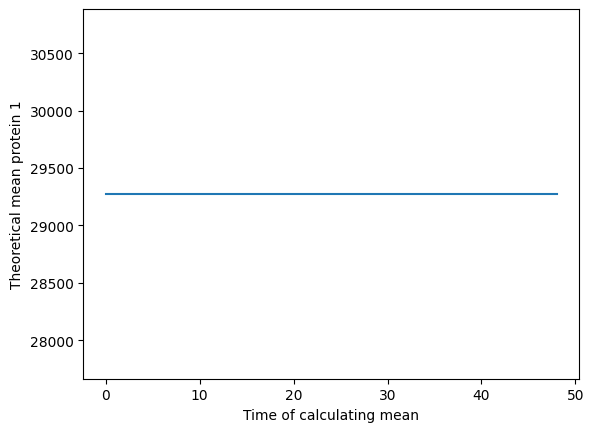

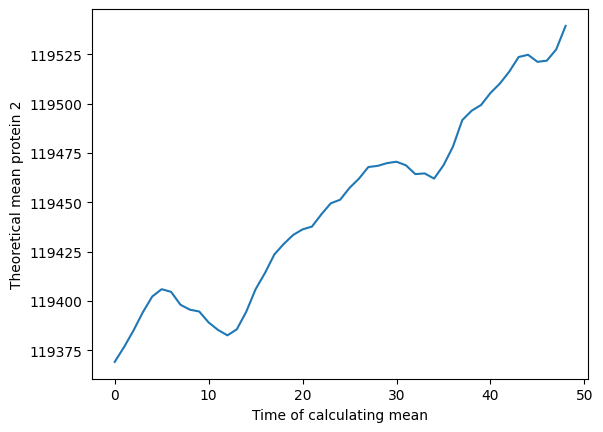

In [9]:
time_steps = df['time_step'].unique()
time_steps
gene_1_mean = []
gene_2_mean = []
for time in tqdm(time_steps):
    steady_state_fixed, steady_state_with_sim_data = steady_state_calc(gene_params, interaction_matrix, gene_list, sim_data = df[df['time_step'] == time])
    gene_1_mean.append(steady_state_with_sim_data[0])
    gene_2_mean.append(steady_state_with_sim_data[1])

plt.plot(time_steps, gene_1_mean)
plt.xlabel("Time of calculating mean")
plt.ylabel("Theoretical mean protein 1")
plt.show()
plt.plot(time_steps, gene_2_mean)
plt.xlabel("Time of calculating mean")
plt.ylabel("Theoretical mean protein 2")
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

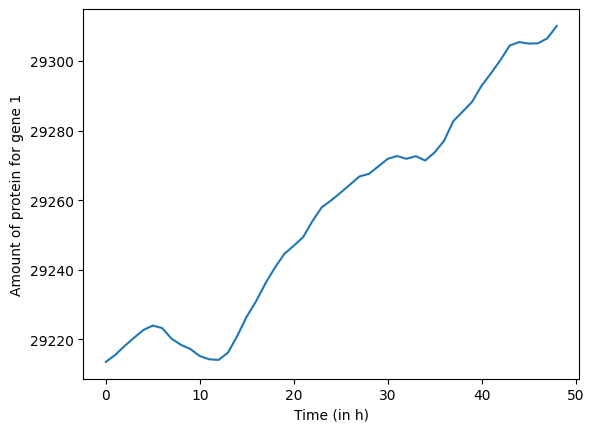

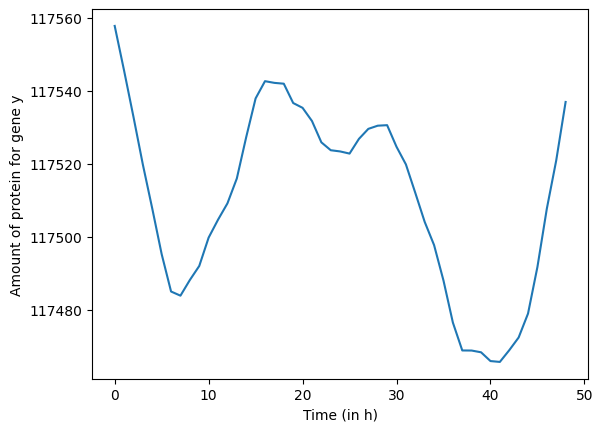

In [18]:
mean_val_1 = []
mean_val_2 = []
t_list = df['time_step'].unique()
for t in tqdm(t_list):
    single_time_point_data = df[df['time_step'] == t]
    mean_val_2.append(single_time_point_data['gene_2_protein'].mean())
    mean_val_1.append(single_time_point_data['gene_1_protein'].mean())

plt.plot(t_list, mean_val_1)
# plt.plot(time_steps, gene_1_mean, linestyle = "--", color = "red")
# plt.axhline(160, linestyle = --)
plt.xlabel("Time (in h)")
plt.ylabel("Amount of protein for gene 1")
# plt.ylim(0, steady_state_with_sim_data[0]+ 5)
plt.show()
plt.plot(t_list, mean_val_2)
# plt.plot(time_steps, gene_2_mean, linestyle = "--", color = "red")
# plt.axhline(350000, linestyle = --)
plt.xlabel("Time (in h)")
plt.ylabel("Amount of protein for gene y")
# plt.ylim(0, steady_state_with_sim_data[1]*1.05)
plt.show()

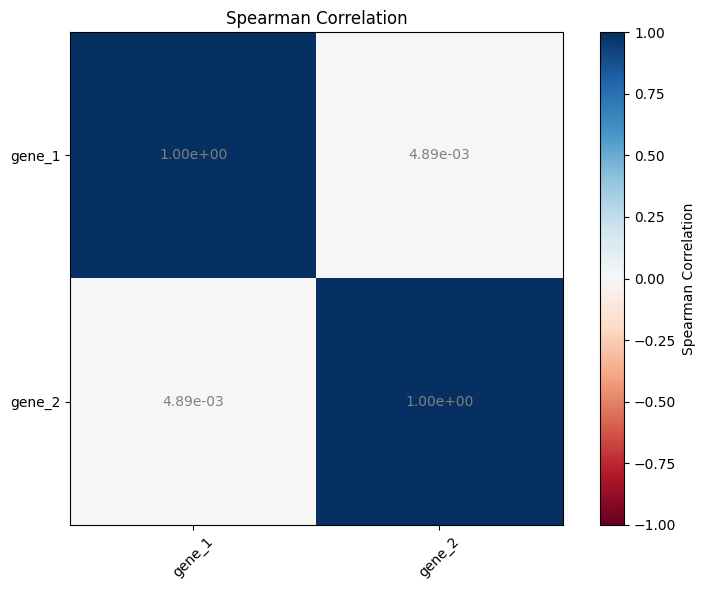

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ----- Parameters -----
time = 10
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_mRNA" for gene in gene_list]


# Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
singleTime_df = df[df['time_step'] == time]

# Split into replicates
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2].reset_index(drop=True)

# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

# Compute correlation matrix
correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
correlation_matrix = dict_to_matrix(correlation_dict, gene_list)

# ----- Step 3: Plot heatmap -----
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix.values, interpolation='nearest', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Spearman Correlation')
plt.xticks(ticks=range(len(gene_list)), labels=gene_list, rotation=45)
plt.yticks(ticks=range(len(gene_list)), labels=gene_list)
plt.title('Spearman Correlation')

# Annotate each cell with correlation value
for i in range(len(gene_list)):
    for j in range(len(gene_list)):
        val = correlation_matrix.iloc[i, j]
        if pd.notnull(val):
            plt.text(j, i, f"{val:.2e}", ha='center', va='center', color='grey')

plt.tight_layout()
plt.show()


In [21]:
df

,cell_id,time_step,gene_1_mRNA,gene_1_protein,gene_2_mRNA,gene_2_protein,replicate,clone_id
0,0,0,1,24949,0,23,1,0
1,0,1,2,25214,0,22,1,0
2,0,2,2,25996,0,21,1,0
3,0,3,2,26645,0,19,1,0
4,0,4,2,27358,0,19,1,0
...,...,...,...,...,...,...,...,...
979995,19999,44,0,33735,0,149,2,9999
979996,19999,45,0,33226,0,149,2,9999
979997,19999,46,1,33042,0,147,2,9999
979998,19999,47,1,33072,0,144,2,9999


Text(0.5, 1.0, '2D Histogram of Gene 2 vs Gene 3 Protein')

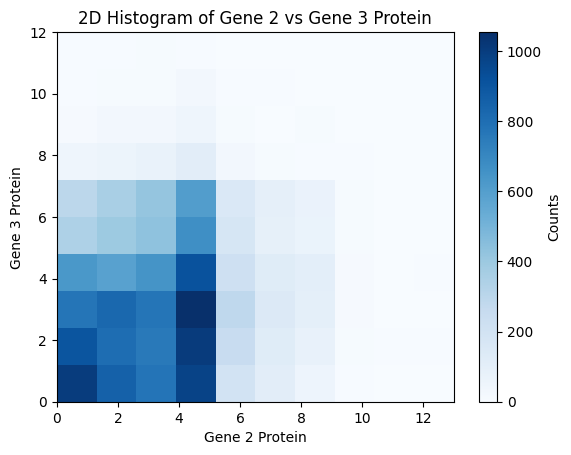

In [59]:
plt.hist(df[df['time_step'] == 10]['gene_3_mRNA'])

# # plt.scatter(df[df['time_step'] == 10]['gene_2_protein'], df[df['time_step'] == 10]['gene_3_protein'])
plt.hist2d(df[df['time_step'] == 10]['gene_3_mRNA'], df[df['time_step'] == 10]['gene_2_mRNA'], bins=10, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Gene 2 Protein')
plt.ylabel('Gene 3 Protein')
plt.title('2D Histogram of Gene 2 vs Gene 3 Protein')

/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning

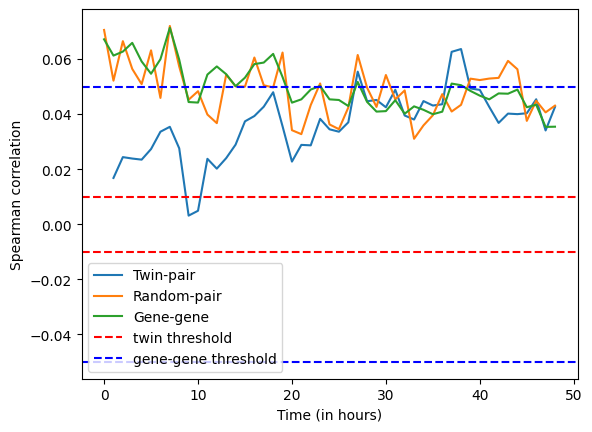

In [68]:
# updated_df = updated_df[updated_df['timestep'] < 1500]
time_points = df['time_step'].unique()
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_mRNA" for gene in gene_list]
corr_list = []
rand_corr_list = []
gene_corr = []
# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

for time in time_points:
    # if time > 1500:
    #     continue
    # Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
    singleTime_df = df[df['time_step'] == time]
    gene_gene_corr = spearmanr(singleTime_df['gene_1_mRNA'], singleTime_df['gene_2_mRNA']).correlation
    # Split into replicates
    rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)
    rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2].reset_index(drop=True)
    rep_shuffled_t1 = rep_1_t1.sample(frac = 1).reset_index(drop=True)


    # Compute correlation matrix
    correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
    corr_rand_dict = calculate_correlation(rep_0_t1, rep_shuffled_t1)
    corr_list.append(correlation_dict['gene_1-gene_2'])
    rand_corr_list.append(corr_rand_dict['gene_1-gene_2'])
    gene_corr.append(gene_gene_corr)

plt.plot(time_points, corr_list, label = "Twin-pair")
plt.plot(time_points, rand_corr_list, label = "Random-pair")
plt.plot(time_points, gene_corr, label = "Gene-gene")
plt.xlabel('Time (in hours)')
plt.ylabel('Spearman correlation')
plt.axhline(0.01, linestyle = "--",  color = "red",label = "twin threshold")
plt.axhline(-0.01, linestyle = "--",  color = "red",)
plt.axhline(0.05, linestyle = "--", color = "blue", label = "gene-gene threshold")
plt.axhline(-0.05, linestyle = "--", color = "blue",)
plt.legend()
plt.show()


/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning

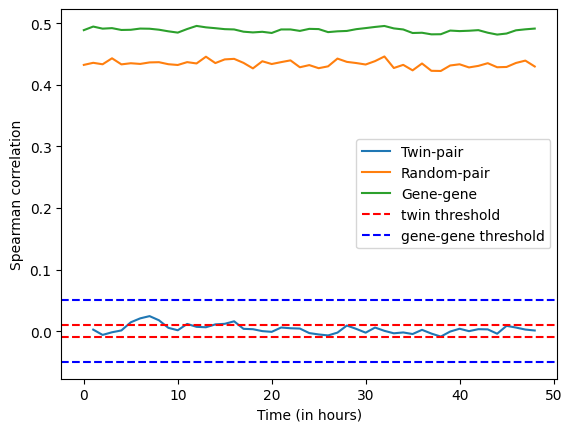

In [19]:
# updated_df = updated_df[updated_df['timestep'] < 1500]
time_points = df['time_step'].unique()
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_mRNA" for gene in gene_list]
corr_list = []
rand_corr_list = []
gene_corr = []
# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

for time in time_points:
    # if time > 1500:
    #     continue
    # Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
    singleTime_df = df[df['time_step'] == time]
    gene_gene_corr = spearmanr(singleTime_df['gene_1_mRNA'], singleTime_df['gene_2_mRNA']).correlation
    # Split into replicates
    rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)
    rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2].reset_index(drop=True)
    rep_shuffled_t1 = rep_1_t1.sample(frac = 1).reset_index(drop=True)


    # Compute correlation matrix
    correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
    corr_rand_dict = calculate_correlation(rep_0_t1, rep_shuffled_t1)
    corr_list.append(correlation_dict['gene_1-gene_2'])
    rand_corr_list.append(corr_rand_dict['gene_1-gene_2'])
    gene_corr.append(gene_gene_corr)

plt.plot(time_points, corr_list, label = "Twin-pair")
plt.plot(time_points, rand_corr_list, label = "Random-pair")
plt.plot(time_points, gene_corr, label = "Gene-gene")
plt.xlabel('Time (in hours)')
plt.ylabel('Spearman correlation')
plt.axhline(0.01, linestyle = "--",  color = "red",label = "twin threshold")
plt.axhline(-0.01, linestyle = "--",  color = "red",)
plt.axhline(0.05, linestyle = "--", color = "blue", label = "gene-gene threshold")
plt.axhline(-0.05, linestyle = "--", color = "blue",)
plt.legend()
plt.show()


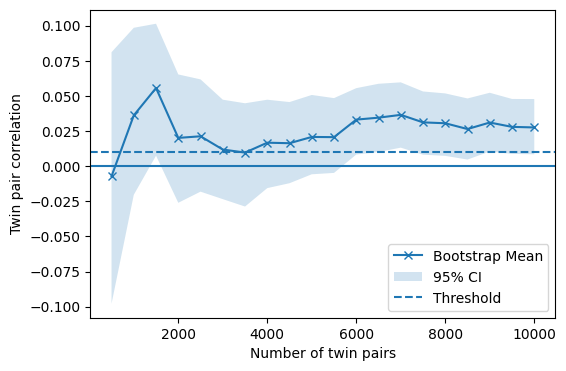

In [67]:
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def bootstrap_correlation(rep_0, rep_1, gene_1, gene_2, n_boot=500):
    n = len(rep_0)
    delta_1 = rep_0[f"{gene_1}_mRNA"].to_numpy() - rep_1[f"{gene_1}_mRNA"].to_numpy()
    delta_2 = rep_0[f"{gene_2}_mRNA"].to_numpy() - rep_1[f"{gene_2}_mRNA"].to_numpy()
    
    corrs = []
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        corrs.append(spearmanr(delta_1[idx], delta_2[idx]).correlation)
    return np.mean(corrs), np.percentile(corrs, 2.5), np.percentile(corrs, 97.5)

# --- Parameters ---
gene_1_gene_2_mean = []
gene_1_gene_2_low = []
gene_1_gene_2_high = []
num_twin_cells = np.arange(500, 10001, 500)
time = 5

# --- Prepare data ---
singleTime_df = df[df['time_step'] == time]

for i in num_twin_cells:
    rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)[:i]
    rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2].reset_index(drop=True)[:i]
    
    mean_corr, low_ci, high_ci = bootstrap_correlation(rep_0_t2, rep_1_t2,
                                                       gene_1="gene_1", gene_2="gene_2",
                                                       n_boot=500)
    gene_1_gene_2_mean.append(mean_corr)
    gene_1_gene_2_low.append(low_ci)
    gene_1_gene_2_high.append(high_ci)

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.plot(num_twin_cells, gene_1_gene_2_mean, marker="x", label="Bootstrap Mean")
plt.fill_between(num_twin_cells, gene_1_gene_2_low, gene_1_gene_2_high,
                 alpha=0.2, label="95% CI")
plt.axhline(0.01, linestyle="--", color="tab:blue", label="Threshold")
plt.axhline(0.0, linestyle="-")
plt.xlabel("Number of twin pairs")
plt.ylabel("Twin pair correlation")
plt.legend()
plt.show()


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def shrink_arrow_endpoints(x1, y1, x2, y2, shrink_source=0.25, shrink_target=0.25, lateral_offset=0.0):
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        return (x1, y1), (x2, y2)
    
    ux, uy = dx / dist, dy / dist  # unit vector
    orth_x, orth_y = -uy, ux  # orthogonal vector
    
    # Apply lateral shift outward
    x1_off = x1 + shrink_source * ux + lateral_offset * orth_x
    y1_off = y1 + shrink_source * uy + lateral_offset * orth_y
    x2_off = x2 - shrink_target * ux + lateral_offset * orth_x
    y2_off = y2 - shrink_target * uy + lateral_offset * orth_y

    return (x1_off, y1_off), (x2_off, y2_off)

def flat_t_head_arrow(start, end, color='red', linewidth=2, rad=0.2, ax=None):
    """Draws a repression-style arrow with a flat T-head."""
    arrow = FancyArrowPatch(
        start, end,
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-',
        color=color,
        linewidth=linewidth,
        zorder=1
    )
    ax.add_patch(arrow)

    x1, y1 = start
    x2, y2 = end
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        return
    ux, uy = dx / dist, dy / dist
    tx, ty = x2, y2
    px, py = -uy, ux
    t_len = 0.05
    t_xs = [tx - px * t_len, tx + px * t_len]
    t_ys = [ty - py * t_len, ty + py * t_len]
    ax.plot(t_xs, t_ys, color=color, linewidth=linewidth, solid_capstyle='round', zorder=2)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# --- Custom merged colormap ---
def make_reds_blues_colormap():
    reds = plt.cm.Reds(np.linspace(1, 0, 128))   # deep red → white
    blues = plt.cm.Blues(np.linspace(0, 1, 128)) # white → deep blue
    colors = np.vstack((reds, blues))
    return LinearSegmentedColormap.from_list('RedsBlues', colors)

def plot_gene_correlation_network(correlation_matrix, gene_list, title=None):
    DG = nx.DiGraph()
    for gene in gene_list:
        DG.add_node(gene)

    # --- Add edges with raw weights ---
    for gene_1 in gene_list:
        self_corr = correlation_matrix.loc[gene_1, gene_1]
        if self_corr == 0 or np.isnan(self_corr):
            continue
        for gene_2 in gene_list:
            if gene_1 == gene_2:
                continue
            raw_weight = correlation_matrix.loc[gene_1, gene_2]
            if pd.isnull(raw_weight):
                continue
            if abs(raw_weight) > 0.04:
                DG.add_edge(gene_1, gene_2, weight=raw_weight/self_corr)

    # --- Node colors (self-correlation) ---
    node_colors = np.array([correlation_matrix.loc[gene, gene] for gene in gene_list])

    # --- Determine color scale dynamically ---
    all_values = list(node_colors) + [DG[u][v]['weight'] for u, v in DG.edges()] if DG.edges else list(node_colors)
    min_val, max_val = min(all_values), max(all_values)

    if min_val >= 0:  # only positive
        vmin, vmax = 0, max_val
        cmap = plt.cm.Blues
    elif max_val <= 0:  # only negative
        vmin, vmax = min_val, 0
        cmap = plt.cm.Reds
    else:  # both positive & negative
        v = max(abs(min_val), abs(max_val))
        vmin, vmax = -v, v
        cmap = make_reds_blues_colormap()

    norm = Normalize(vmin=vmin, vmax=vmax)
    node_rgba = cmap(norm(node_colors))
    node_rgba[:, -1] = 0.8  # transparency

    # --- Draw graph ---
    pos = nx.spring_layout(DG, seed=42)
    fig, ax = plt.subplots(figsize=(9, 9))
    nx.draw_networkx_nodes(DG, pos, ax=ax, node_color=node_rgba, node_size=4000,
                           edgecolors='black', linewidths=1.5)
    nx.draw_networkx_labels(DG, pos, font_size=14, font_weight='bold', ax=ax)

    # --- Draw edges using same colormap ---
    for u, v in DG.edges():
        weight = DG[u][v]['weight']
        color = cmap(norm(weight))
        abs_weight = abs(weight)
        rad = 0.25 if DG.has_edge(v, u) else 0.0
        offset = -0.2 if DG.has_edge(v, u) else 0.0

        x1, y1 = pos[u]
        x2, y2 = pos[v]
        start, end = shrink_arrow_endpoints(x1, y1, x2, y2, lateral_offset=offset)

        if weight > 0:
            arrow = FancyArrowPatch(
                start, end,
                connectionstyle=f'arc3,rad={rad}',
                arrowstyle='-|>',
                mutation_scale=20 + abs_weight * 10,
                color=color,
                linewidth=max(abs_weight * 15, 1.0),
                zorder=1
            )
            ax.add_patch(arrow)
        else:
            flat_t_head_arrow(start, end, color=color,
                              linewidth=max(abs_weight * 15, 1.0),
                              rad=rad, ax=ax)

    # --- Colorbar ---
    sm = ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Correlation (negative → red, positive → blue)', fontsize=12)

    # --- Layout ---
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()

    # Adjust margins
    if len(pos) > 0:
        x_vals, y_vals = zip(*pos.values())
        if all(np.isfinite(x_vals)) and all(np.isfinite(y_vals)):
            x_range = max(x_vals) - min(x_vals)
            y_range = max(y_vals) - min(y_vals)
            x_margin = 0.3 * x_range if x_range > 0 else 1
            y_margin = 0.3 * y_range if y_range > 0 else 1
            ax.set_xlim(min(x_vals) - x_margin, max(x_vals) + x_margin)
            ax.set_ylim(min(y_vals) - y_margin, max(y_vals) + y_margin)

    plt.tight_layout()
    return fig, ax, sm  # sm is useful for modifying the colorbar later if needed





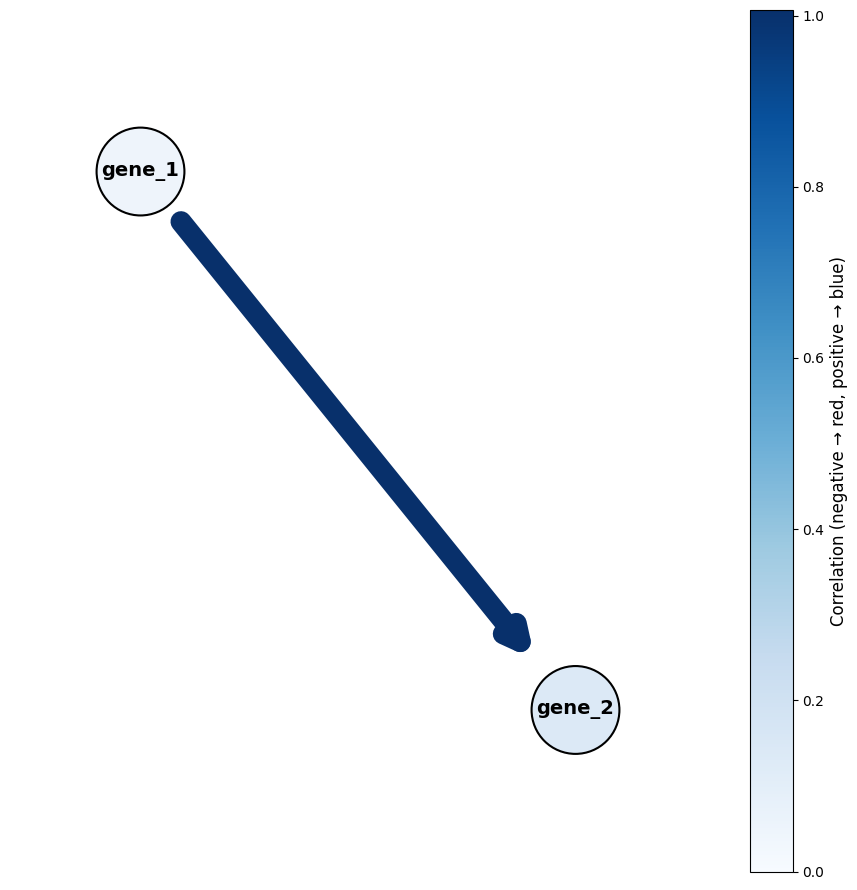

In [39]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_a_b_basic = plot_gene_correlation_network(correlation_matrix, gene_list)

In [10]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 15
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

NameError: name 'plot_gene_correlation_network' is not defined

In [154]:
correlation_matrix

,gene_1,gene_2
gene_1,0.278573,0.177245
gene_2,0.078603,0.451015


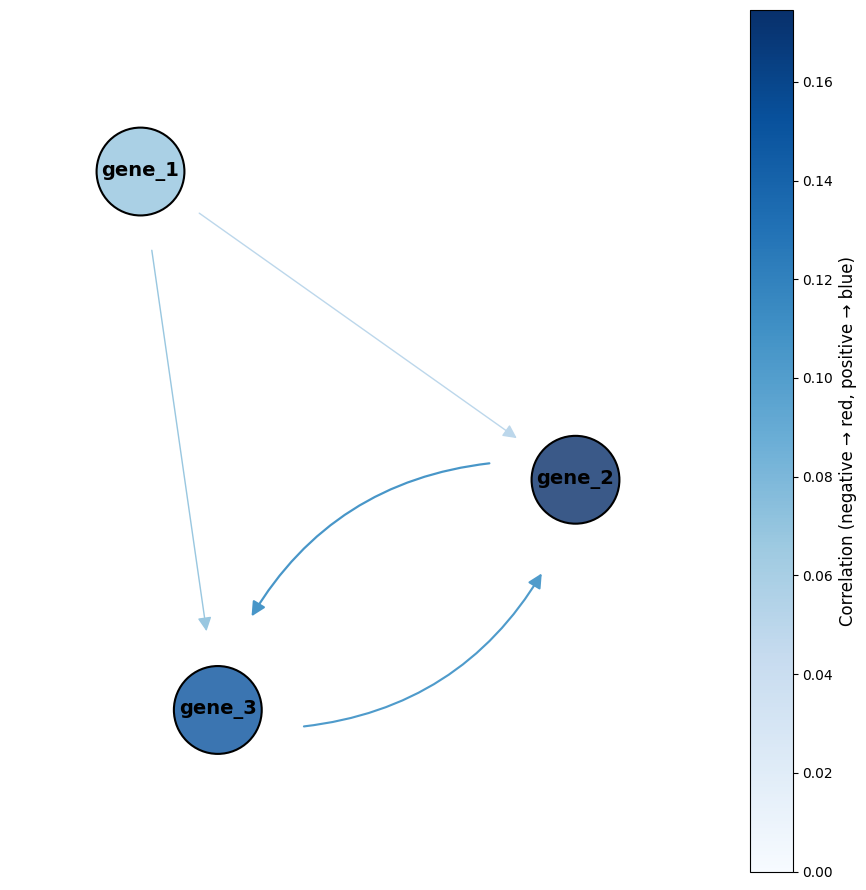

In [146]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 3
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

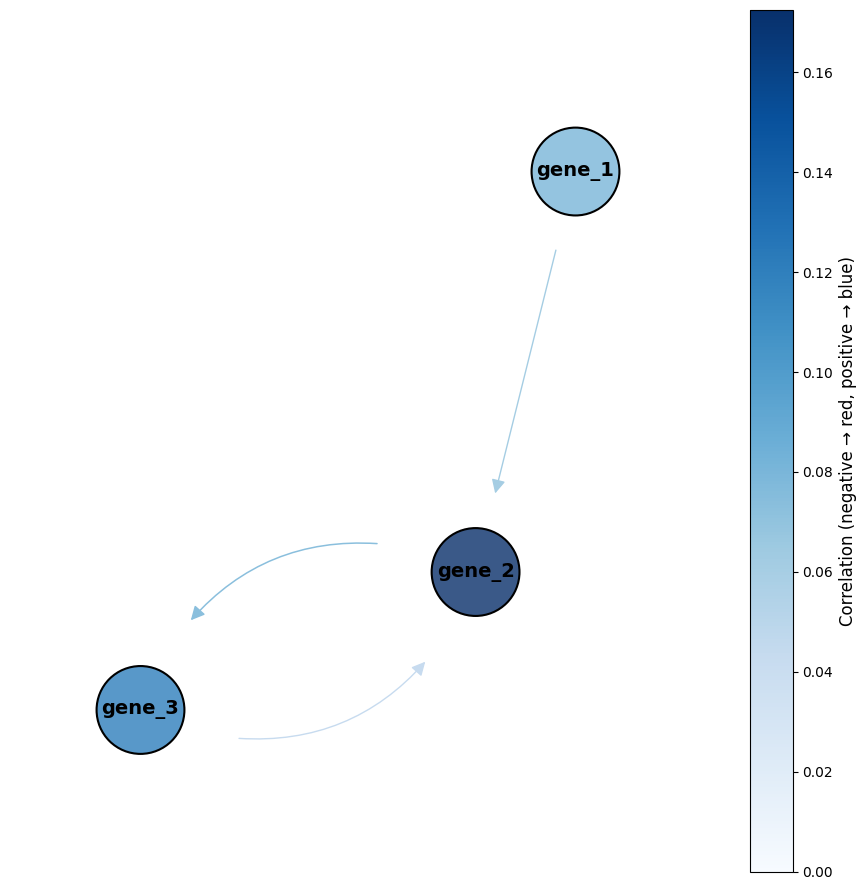

In [138]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 3
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

In [136]:
correlations

{'gene_1->gene_1': 0.07959428918453586,
 'gene_1->gene_2': 0.060751688835918256,
 'gene_1->gene_3': 0.004309995008912557,
 'gene_2->gene_1': 0.009033888706019663,
 'gene_2->gene_2': 0.17247428795265482,
 'gene_2->gene_3': 0.07292036445596793,
 'gene_3->gene_1': -0.0032313247226118435,
 'gene_3->gene_2': 0.042576028943928486,
 'gene_3->gene_3': 0.1209360441519313}

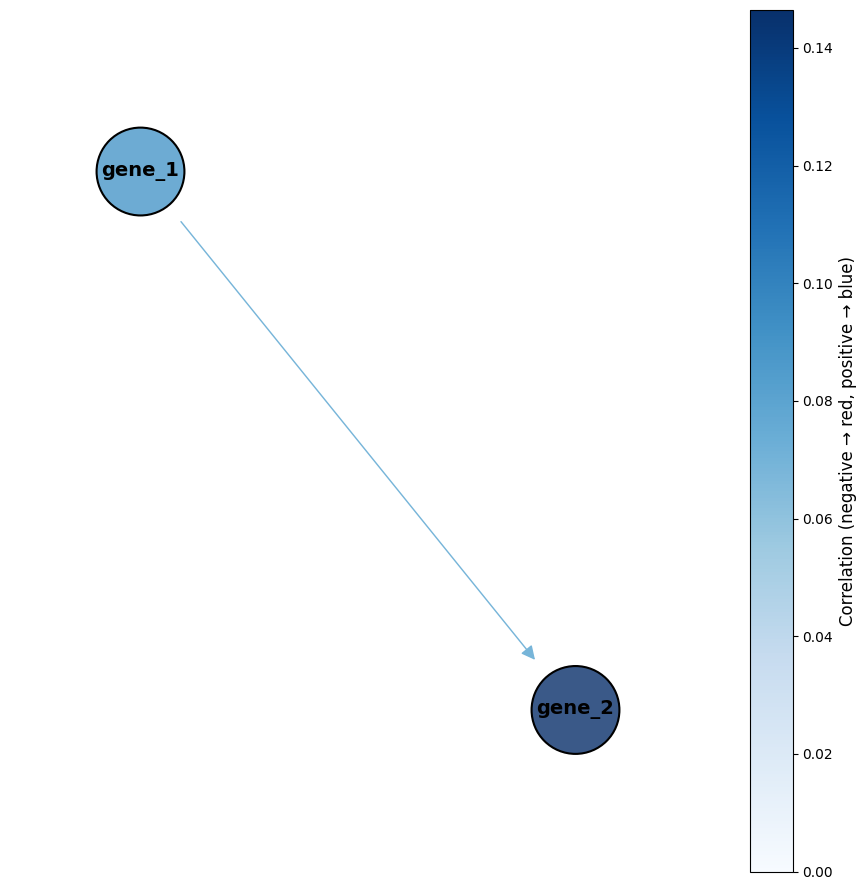

In [129]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

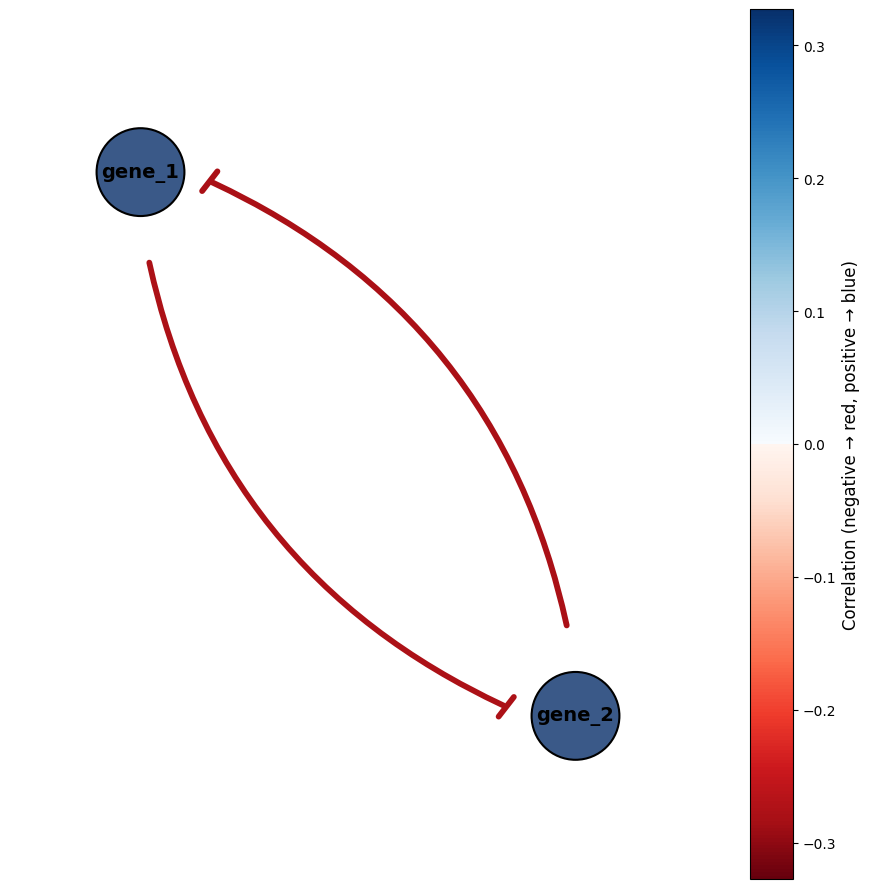

In [119]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

-0.7661460225457533 red


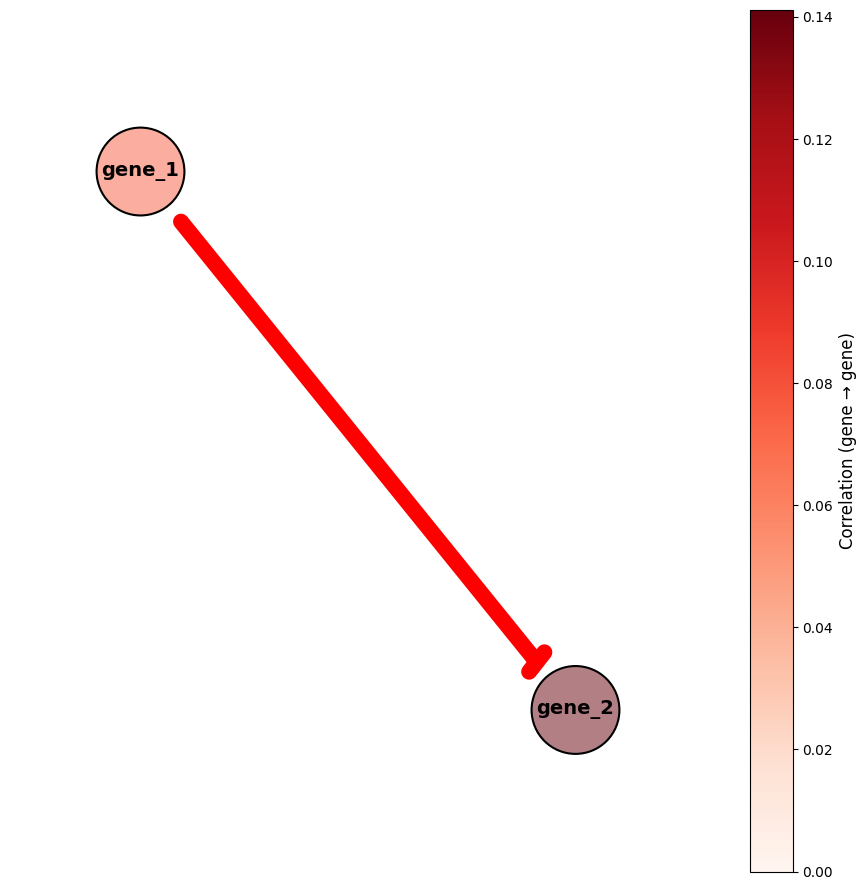

In [78]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

In [ ]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

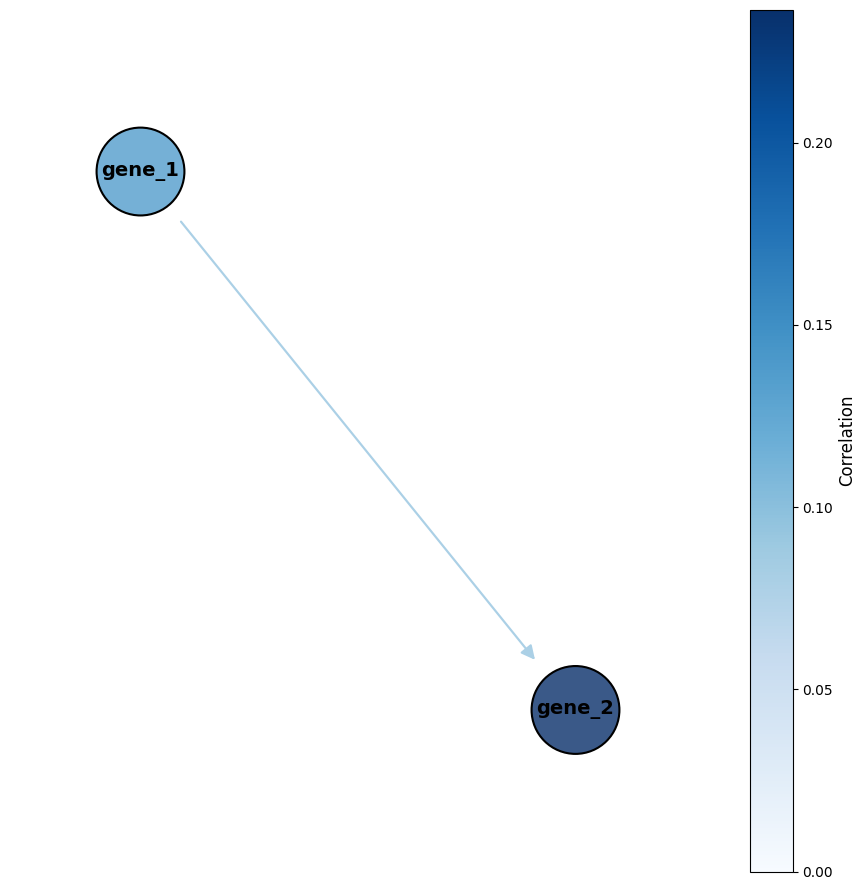

In [89]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

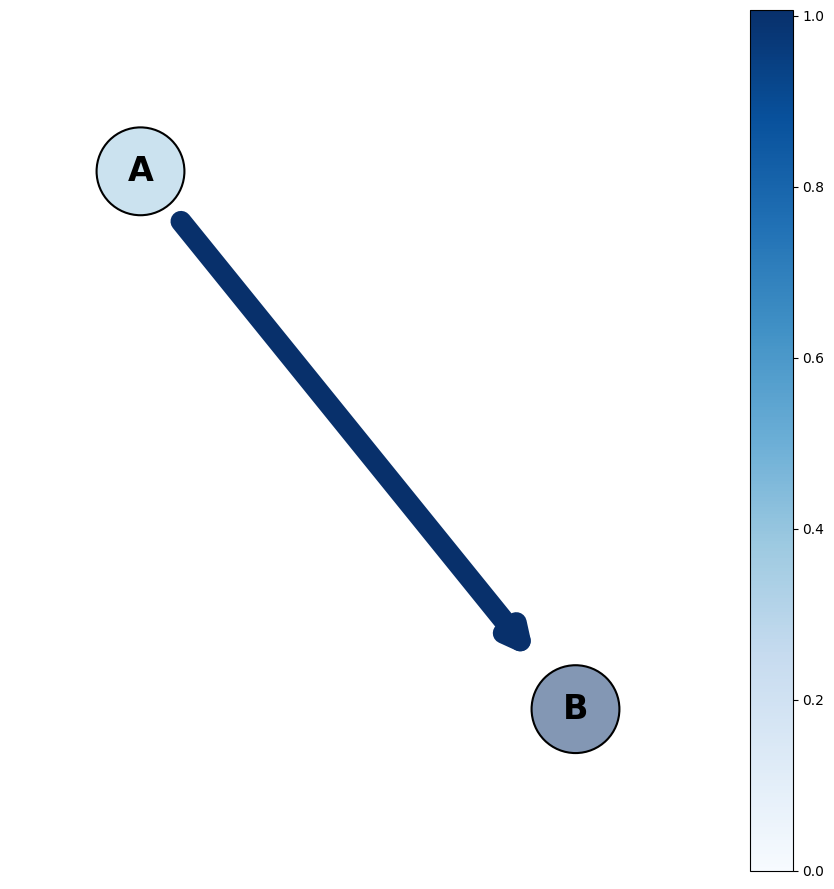

In [33]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)

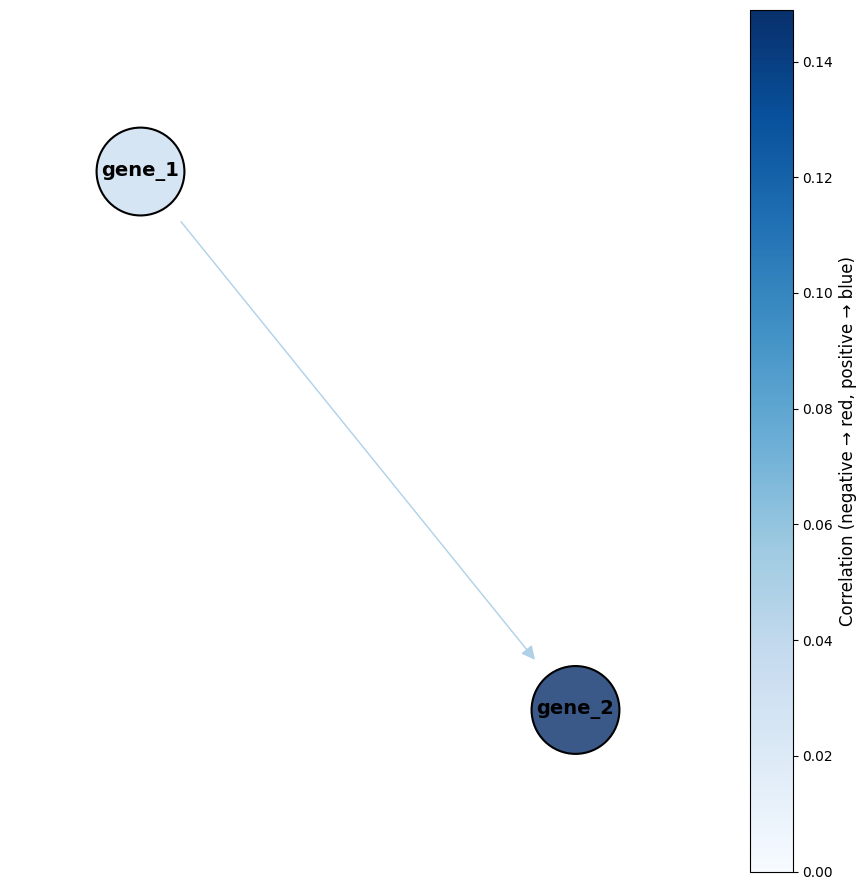

$r_{add}$ = 8


In [171]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 15
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)
print(r"$r_{add}$ = 8")

In [170]:
correlation_matrix

,gene_1,gene_2
gene_1,0.032760,0.048593
gene_2,0.011321,0.148909


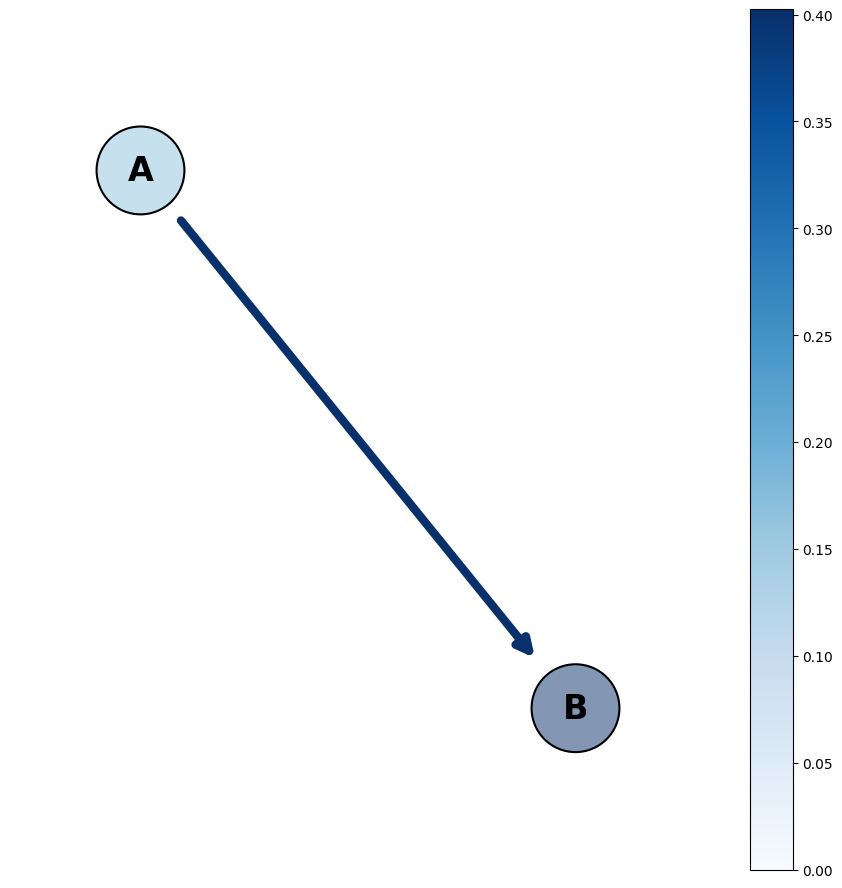

In [50]:
from matplotlib.patches import FancyArrowPatch
import networkx as nx

t1 = 5
singleTime_df = df[df['time_step'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
t2 = 10
singleTime_df = df[df['time_step'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list)